In [1]:
from lcode2dPy.simulation.interface import Simulation
from lcode2dPy.diagnostics.targets import BeamDiagnostics
from lcode2dPy.config.default_config import default_config
from lcode2dPy.beam.beam_generator import make_beam, Gauss, rGauss
import numpy as np
import matplotlib.pyplot as plt
import subprocess

In [2]:
# Параметры

time_step       = 200
time_limit      = 200.5
window_length   = 0.5
window_width    = 3
r_step          = 0.01
xi_step         = 0.01

In [3]:
# Config
config = default_config
config.set('time-step', time_step)
config.set('time-limit', time_limit)
config.set('window-length', window_length)
config.set('window-width', window_width)
config.set('r-step', r_step)
config.set('xi-step', xi_step)

# Beam
gamma = 426
angspread = 1e-5
m_proton = 958/0.51

beam_pars = dict(xi_distr=Gauss(sigma=100, vmin=-window_length, vmax=0),
                r_distr=rGauss(vmin=0, vmax=window_width),
                ang_distr=Gauss(sigma=angspread, vmin=None, vmax=None),
                pz_distr=Gauss(gamma*m_proton, gamma*m_proton*1e-4, vmin=None, vmax=None),
                Ipeak_kA=2*40/1000,
                q_m=1/m_proton,
                saveto=".")

diagnostics = [
    BeamDiagnostics(period=200)
]

sim = Simulation(beam_pars=beam_pars, diagnostics=diagnostics, config=config)

In [4]:
!rm beamfile.bin

In [5]:
sim.step(int(time_limit//time_step))

Number of particles: 52229
Number of particles in the middle layer: 522


In [6]:
!rm ../c_code/*
!cp beamfile.bin ../c_code/beamfile.bin 

config.c_config("../c_code/lcode.cfg")
!echo 0 > ../c_code/beamfile.bit

p = subprocess.Popen(["/home/global/lcode/lcode", "lcode.cfg"], cwd="../c_code")
p.wait()

0

In [7]:
beam_slice = sim.beam_source.get_beam_slice(10, -config.getfloat('window-length'))
beam_python1 = beam_slice.particles

In [8]:
particle_dtype = np.dtype([('xi', 'f8'), ('r', 'f8'), ('p_z', 'f8'), ('p_r', 'f8'), ('M', 'f8'), ('q_m', 'f8'),
                           ('q_norm', 'f8'), ('id', 'i8')])
beam_before = np.fromfile("beamfile.bin", dtype = particle_dtype)[:-1]
beam_c = np.fromfile("../c_code/beamfile.bin", dtype=particle_dtype)[:-1]
beam_python2 = diagnostics[0].data[200]


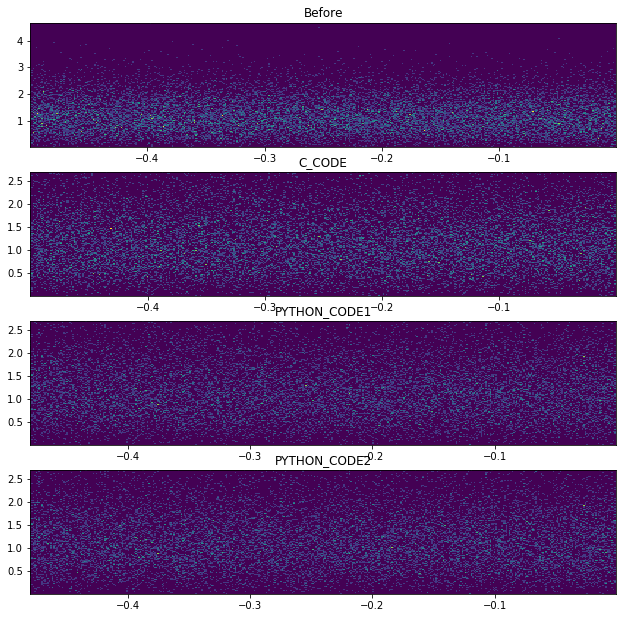

In [9]:
bins = 400
plt.subplot(411)
plt.hist2d(beam_before['xi'], beam_before['r'], bins=bins);
plt.title('Before')
plt.subplot(412)
plt.hist2d(beam_c['xi'], beam_c['r'], bins=bins);
plt.title('C_CODE')
plt.subplot(413)
plt.hist2d(beam_python1['xi'], beam_python1['r'], bins=bins);
plt.title('PYTHON_CODE1')
plt.subplot(414)
plt.hist2d(beam_python2['xi'], beam_python2['r'], bins=bins);
plt.title('PYTHON_CODE2')
fig = plt.gcf()
fig.set_size_inches(10.5, 10.5)
plt.plot();

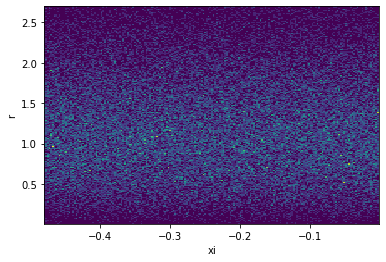

In [18]:
beam = beam_slice.particles
plt.hist2d(beam['xi'], beam['r'], 200);
plt.xlabel('xi')
plt.ylabel('r');

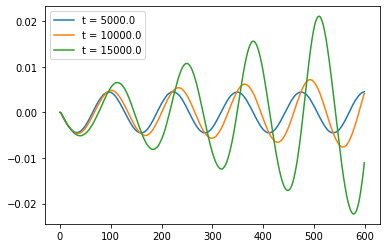

In [16]:
beam_slice = sim.beam_source.get_beam_slice(10, -config.getfloat('window-length'))

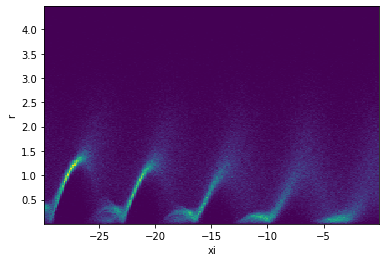

In [17]:
beam = beam_slice.particles
plt.hist2d(beam['xi'], beam['r'], 200);
plt.xlabel('xi')
plt.ylabel('r');